In [1]:
### Mount GDrive To Colab
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
### Locate Images Directory
from os import listdir
from os.path import join

MY_DRIVE = join("drive", "My Drive")
WD = join(MY_DRIVE, "WA Challenge")
IMAGE_DIR = join(WD, "img")

print(f"Working Dir: {listdir(WD)}")
print(f"  Image Dir: {listdir(IMAGE_DIR)}")

Working Dir: ['img', 'Main.ipynb']
  Image Dir: ['red.png', 'answer.png']


In [3]:
### Imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [4]:
### Constants
SRC_NAME = "red.png"
DEST_NAME = "answer.png"

In [5]:
### Load In Source Image & Make Copy
SRC_IMAGE = cv.imread(join(IMAGE_DIR, SRC_NAME))
cones = np.copy(SRC_IMAGE)

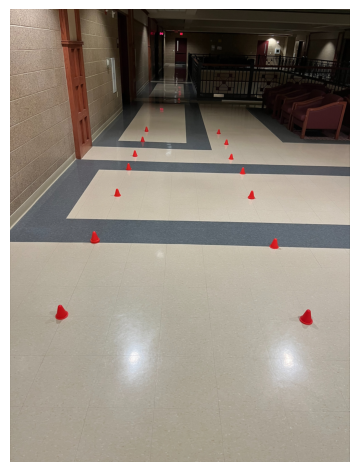

In [6]:
### Preview Source Image
def printImage(img):
  figure(figsize=(8, 6), dpi=100)
  plt.axis('off')
  rgbImage = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  plt.imshow(rgbImage)
  plt.show()

printImage(cones)

In [7]:
### Data Properties
# 2420 Rows
# 1816 Columns
# Blue, Green, Red Channels
print(cones.shape)

(2420, 1816, 3)


In [8]:
### Slightly Blur Image
# Apply Gaussian Blur with (5,5) kernel to reduce noise
cones = cv.GaussianBlur(cones, (5,5), 0)

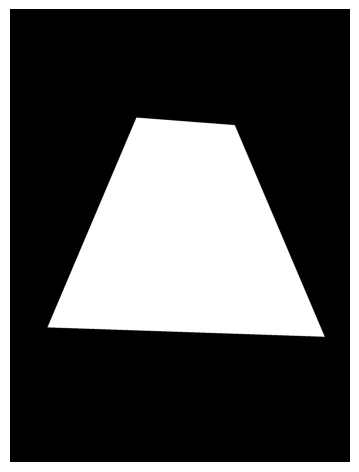

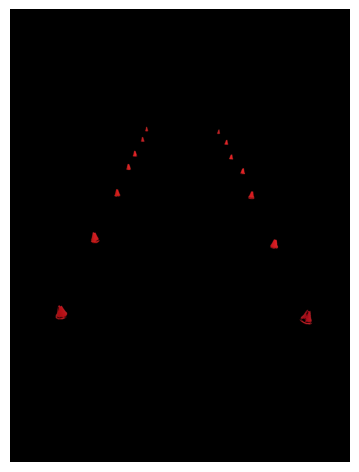

In [9]:
### Bitwise Mask Filtering
# Filter Out Cones By Red Color
lowerBound = np.array([10,  10, 150])
upperBound = np.array([50, 255, 255])
colorMask = cv.inRange(cones, lowerBound, upperBound)

# Filter Out Cones By Relevant Area Polygon
polygons = np.array([[
  (675, 580), (200, 1700), (1680, 1750), (1200, 620)
]])
areaMask = np.zeros_like(colorMask)
cv.fillPoly(areaMask, polygons, 255)

# Merge Area Mask Into Color Mask
# In other words, all pixels that were within color threshold
# but outside region of interest are ignored
colorMask = cv.bitwise_and(colorMask, areaMask)
printImage(areaMask)

# Apply Mask
conesMasked = cv.bitwise_and(cones, cones, mask=colorMask)
printImage(conesMasked)

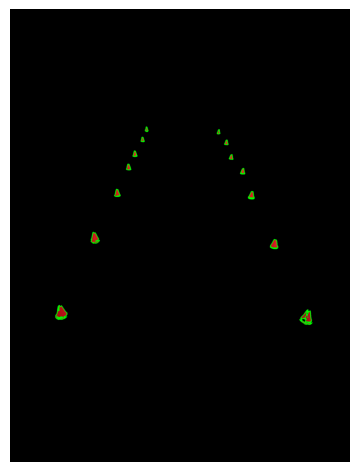

In [10]:
### Find Contours From Masked Cones
# A cautionary step in case non-cone pixels within the
# area of interest are within the color threshold 
contours, _ = cv.findContours(
  colorMask, 
  mode=cv.RETR_TREE, 
  method=cv.CHAIN_APPROX_NONE
)

conesContoured = np.copy(conesMasked)
cv.drawContours(conesContoured, contours, -1, (0,255,0), 3)

printImage(conesContoured)

     min: (244, 1636)
 maxLeft: (737, 651)
minRight: (1106, 662)
     max: (1613, 1676)


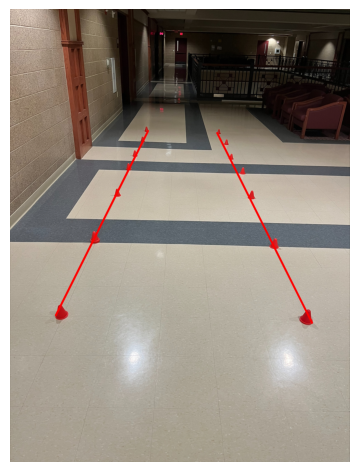

In [11]:
### Find Initial Line Points
# Split scree into half finding the min and max
# contour points on each side respectively
width = cones.shape[1]
mid = width / 2

min = (width, width)      # Minimum X Overall
max = (0, 0)              # Maximum X Overall
maxLeft = (0, 0)          # Max X On The Left Half
minRight = (width, width) # Min X On The Right Half

for contour in contours:
  contour = contour.reshape(-1, 2) # Reshape to some N of (x,y) pairs
  for x, y in contour:
    if x < min[0]:
      min = (x, y)
    if x > max[0]:
      max = (x, y)
    if x < mid and x > maxLeft[0]:
      maxLeft = (x, y)
    if x > mid and x < minRight[0]:
      minRight = (x, y)

print(f"     min: {min}")
print(f" maxLeft: {maxLeft}")
print(f"minRight: {minRight}")
print(f"     max: {max}")

conesWithLines = np.copy(SRC_IMAGE)
cv.line(conesWithLines,      min, maxLeft, color=(0,0,255), thickness=10)
cv.line(conesWithLines, minRight,     max, color=(0,0,255), thickness=10)
printImage(conesWithLines)

In [12]:
### Extend Initial Lines Past Screen
def getSlope(pt1, pt2):
  """Gets the slope between two points"""
  x1, y1 = pt1
  x2, y2 = pt2

  return (y2 - y1) / (x2 - x1)

def extendPt(pt, m, delta):
  """Returns a point displaced by a delta value"""
  return (pt[0] + delta, int(pt[1] + m*delta))

slopeLeft = getSlope(min, maxLeft)
extMin = extendPt(min, slopeLeft, -500)
extMaxLeft = extendPt(maxLeft, slopeLeft, 500)

slopeRight = getSlope(minRight, max)
extMinRight = extendPt(minRight, slopeRight, -500)
extMax = extendPt(max, slopeRight, 500)

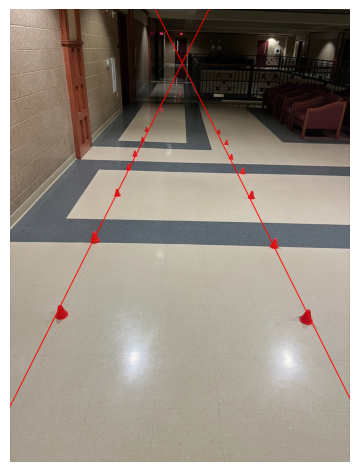

In [13]:
### Generate & Save The Solution
# Overlays the extended lines on the source image
solution = np.copy(SRC_IMAGE)

cv.line(solution, extMin, extMaxLeft, (0,0,255), 3)
cv.line(solution, extMinRight, extMax, (0,0,255), 3)

cv.imwrite(join(IMAGE_DIR, DEST_NAME), solution)
printImage(solution)